In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import time
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import missingno as msno

# Data Preparation

### Load Data

In [2]:
clean_hdb_df1 = pd.read_csv('Processed_Data/hdb_data_with_coords_mrt_dist_id.csv',
    parse_dates=['month', 'lease_commence_date'])

# copy
df = clean_hdb_df1.copy()

### Exploratory Data Analysis

=== Data Quality Report ===

1. Basic Information:
Rows: 962,946
Columns: 23

2. Data Types:
remaining_lease                float64
floor_area_sqm                 float64
storey_range                    object
street_name                     object
lease_commence_date     datetime64[ns]
month                   datetime64[ns]
flat_type                       object
resale_price                   float64
town                            object
block                           object
flat_model                      object
storey_range_min                 int64
storey_range_max                 int64
full_address                    object
Latitude                       float64
Longitude                      float64
nearest_mrt_id                  object
mrt_name                        object
mrt_latitude                   float64
mrt_longitude                  float64
mrt_road                        object
Distance_from_MRT_km           float64
transaction_id                   int64
dtype: obj

/var/folders/y_/h86dm1h150v7bstq3mkcv4gm0000gn/T/ipykernel_5391/2745395831.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1000x600 with 0 Axes>

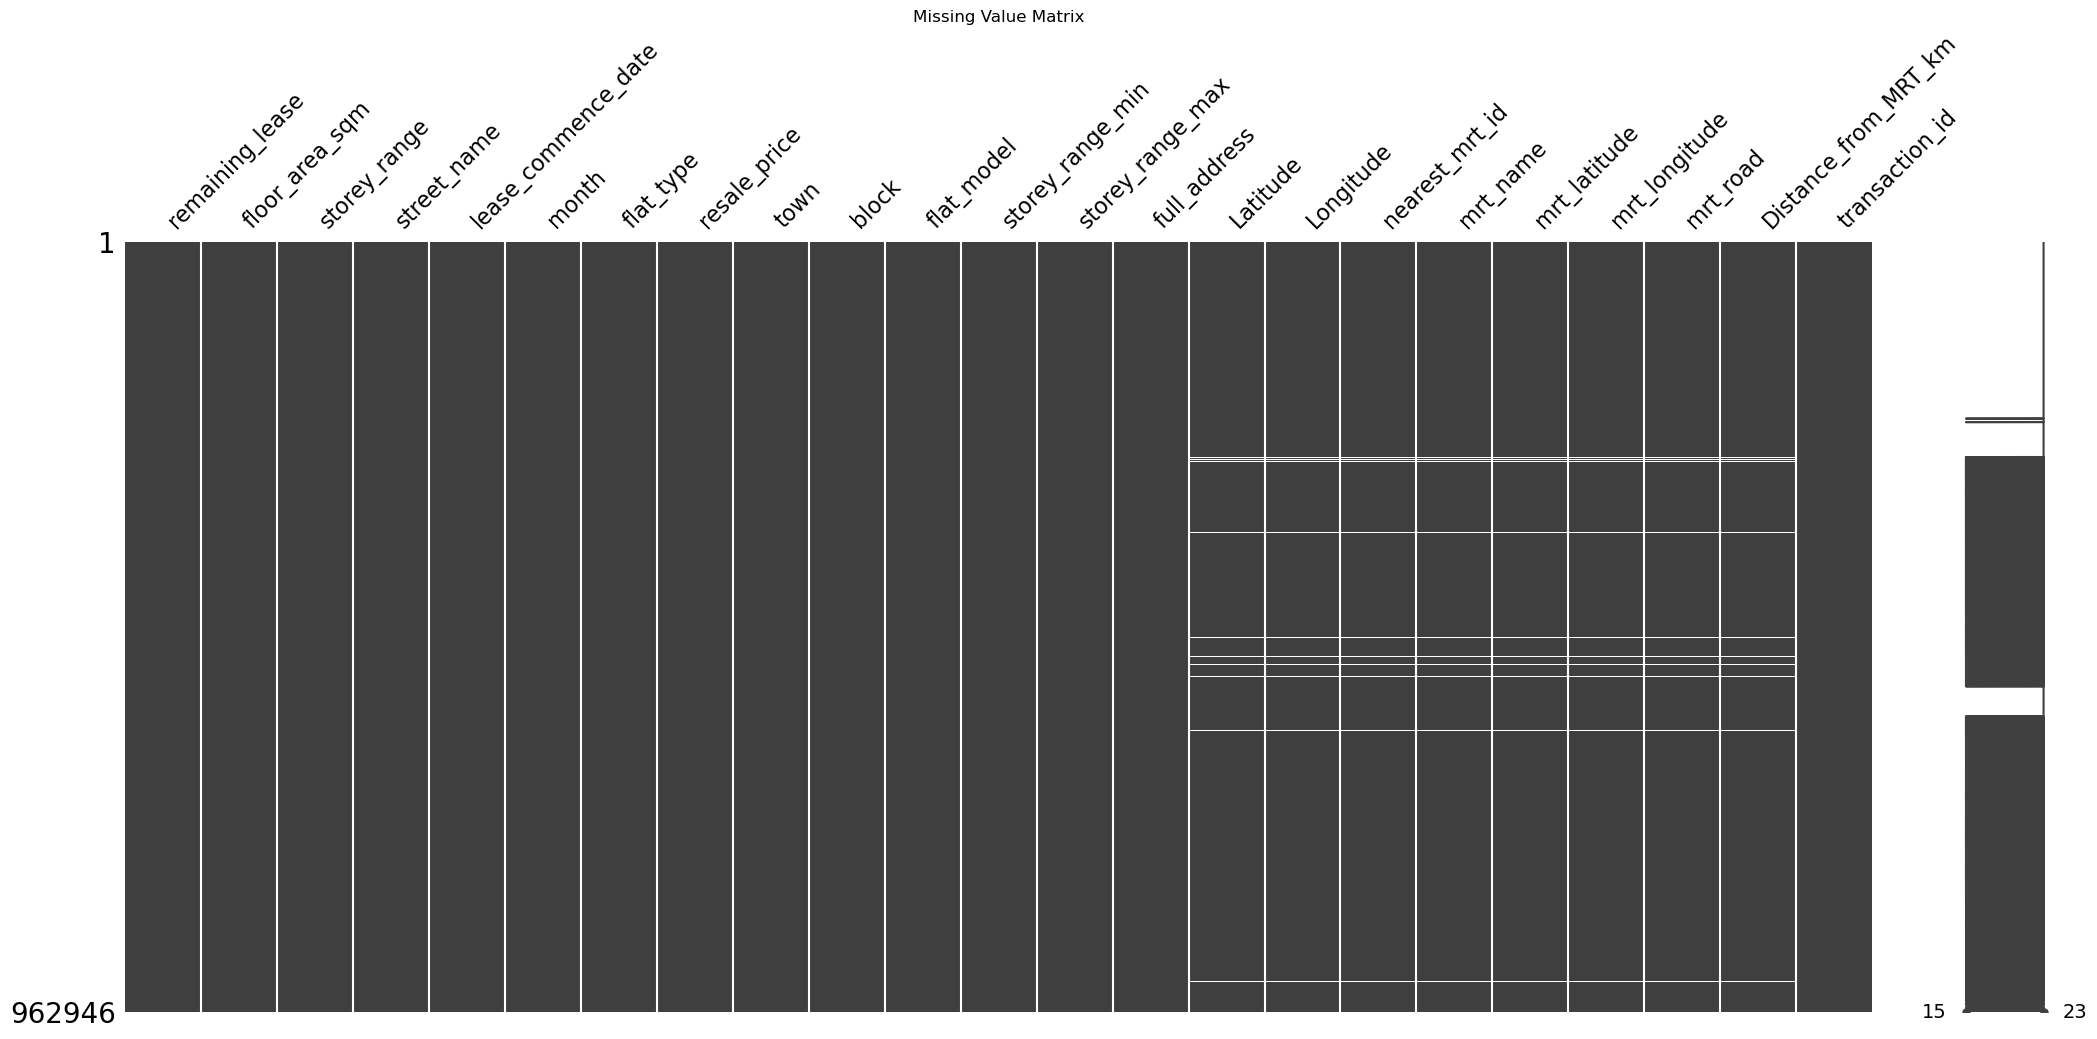

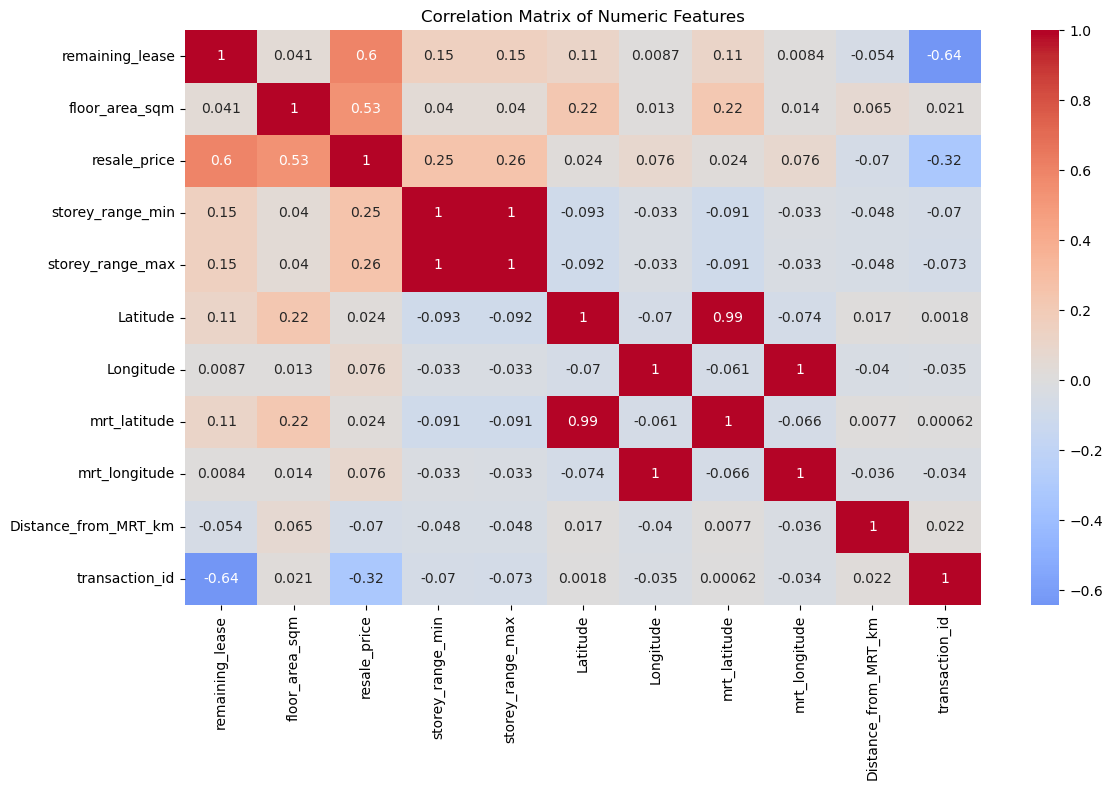

In [3]:
def check_data_quality(df):
    """
    Comprehensive data quality check for DataFrame
    """
    print("=== Data Quality Report ===\n")
    
    # Basic DataFrame Info
    print("1. Basic Information:")
    print(f"Rows: {df.shape[0]:,}")
    print(f"Columns: {df.shape[1]:,}")
    print("\n2. Data Types:")
    print(df.dtypes)
    
    # Missing Values
    print("\n3. Missing Values:")
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    missing_df = pd.DataFrame({
        'Missing Values': missing,
        'Percentage': missing_pct
    })
    print(missing_df[missing_df['Missing Values'] > 0])
    
    # Infinite Values
    print("\n4. Infinite Values:")
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    inf_counts = {col: np.sum(~np.isfinite(df[col])) for col in numeric_cols}
    inf_df = pd.DataFrame.from_dict(inf_counts, orient='index', columns=['Count'])
    print(inf_df[inf_df['Count'] > 0])
    
    # Zero Values (for numeric columns)
    print("\n5. Zero Values (numeric columns):")
    zero_counts = {col: (df[col] == 0).sum() for col in numeric_cols}
    zero_pct = {col: (zero_counts[col] / len(df)) * 100 for col in numeric_cols}
    zeros_df = pd.DataFrame({
        'Zero Count': zero_counts,
        'Zero Percentage': zero_pct
    })
    print(zeros_df[zeros_df['Zero Count'] > 0])
    
    # Unique Values (for categorical columns)
    print("\n6. Unique Values (categorical columns):")
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    for col in categorical_cols:
        n_unique = df[col].nunique()
        print(f"{col}: {n_unique:,} unique values")
    
    # Memory Usage
    print("\n7. Memory Usage:")
    memory_usage = df.memory_usage(deep=True).sum() / 1024**2  # in MB
    print(f"Total Memory Usage: {memory_usage:.2f} MB")

# Run the analysis
check_data_quality(df)

#Visual missing value analysis using missingno
plt.figure(figsize=(10, 6))
msno.matrix(df)
plt.title("Missing Value Matrix")
plt.tight_layout()
plt.show()

# Optional: Correlation heatmap for numeric columns
plt.figure(figsize=(12, 8))
sns.heatmap(df.select_dtypes(include=[np.number]).corr(), 
            annot=True, 
            cmap='coolwarm', 
            center=0)
plt.title("Correlation Matrix of Numeric Features")
plt.tight_layout()
plt.show()

# Filter Data Required for Model

In [4]:
def filter_data_for_modeling(clean_hdb_df, year_cutoff=2013):
    # Ensure month and lease_commence_date are datetime
    df = clean_hdb_df.copy()

    # Drop rows with missing or invalid price
    df = df[df["resale_price"].notnull() & (df["resale_price"] > 0)]

    #date type
    df["month"] = pd.to_datetime(df["month"])
    df["lease_commence_date"] = pd.to_datetime(df["lease_commence_date"], errors='coerce')

    # Features
    feature_df = pd.DataFrame({
        "transaction_id": df["transaction_id"],
        "resale_year": df["month"].dt.year,
        "town": df["town"],
        "flat_type": df["flat_type"],
        "flat_age": ((df["month"] - df["lease_commence_date"]).dt.days / 365.25).clip(lower=0),
    })

    # Targets (log-transform)
    target_df = pd.DataFrame({
        "transaction_id": df["transaction_id"],
        "resale_price": df["resale_price"]
    })

    # Split into past and future
    past_mask = feature_df["resale_year"] <= year_cutoff
    future_mask = feature_df["resale_year"] > year_cutoff

    past_feature_df = feature_df[past_mask].copy()
    future_feature_df = feature_df[future_mask].copy()

    past_target_df = target_df[past_mask].copy()
    future_target_df = target_df[future_mask].copy()

    return past_feature_df, past_target_df, future_feature_df, future_target_df


In [5]:
past_feature_df, past_target_df, future_feature_df, future_target_df = filter_data_for_modeling(df, year_cutoff=2013)

Test Train split on past data

In [6]:
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(
    past_feature_df, past_target_df, test_size=0.2, random_state=42
)


# One-hot encode categoricals, scale numerics

In [7]:
def preprocess_features_pipeline(feature_df, numeric_features=None, categorical_features=None, preprocessor=None, fit=True):
    df = feature_df.copy()
    if "transaction_id" in df.columns:
        df = df.drop(columns=["transaction_id"])

    if numeric_features is None:
        numeric_features = df.select_dtypes(include=["float64", "int64"]).columns.tolist()
    if categorical_features is None:
        categorical_features = df.select_dtypes(include=["object", "category"]).columns.tolist()

    if preprocessor is None:
        preprocessor = ColumnTransformer(transformers=[
            ("num", StandardScaler(), numeric_features),
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features)
        ])

    if fit:
        X_processed = preprocessor.fit_transform(df)
    else:
        X_processed = preprocessor.transform(df)

    return X_processed, preprocessor


In [8]:
categorical_cols = ["town", "flat_type"]
numeric_cols = ["resale_year", "flat_age"]

In [9]:
X_train, preprocessor = preprocess_features_pipeline(X_train_df, numeric_cols, categorical_cols, fit=True)
X_test, _ = preprocess_features_pipeline(X_test_df, numeric_cols, categorical_cols, preprocessor=preprocessor, fit=False)
X_future, _ = preprocess_features_pipeline(future_feature_df, numeric_cols, categorical_cols, preprocessor=preprocessor, fit=False)


# Modeling

Random Forest Model (can be slower than XGBoost, but not significant)

In [10]:
rf_model = RandomForestRegressor(
    n_estimators=500, # number of trees, 100–1000 depending on dataset size.
    max_depth=10, #None,    # grow trees fully; or set e.g., 10–20, limit to prevent overfitting if dataset is small.
    min_samples_split=2, # min samples to split a node
    min_samples_leaf=1, # min samples per leaf, increase to smooth predictions.
    n_jobs=-1,    # use all cores
    random_state=42,
    
)

In [11]:
# convert df to np array
y_train = y_train_df["resale_price"].values.astype(float)

Model Training

In [12]:


rf_model.fit(X_train,y_train)



,n_estimators,500
,criterion,'squared_error'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## Model Testing

In [13]:
y_test_predict=rf_model.predict(X_test)

In [14]:
y_test = y_test_df["resale_price"].values.astype(float)
rmse = np.sqrt(mean_squared_error(y_test, y_test_predict))
mape = np.mean(np.abs((y_test - y_test_predict) / y_test)) * 100
r2 = r2_score(y_test, y_test_predict)

print(f"Test RMSE: {rmse:.2f}")
print(f"Test Mean Absolute Percentage Error: {mape:.2f}%")
print(f"Test R^2 (Coefficient of Determination): {r2:.4f}")

if r2>0.9:
    print("Your predictive model is excellent!!")

Test RMSE: 42459.77
Test Mean Absolute Percentage Error: 12.19%
Test R^2 (Coefficient of Determination): 0.8965


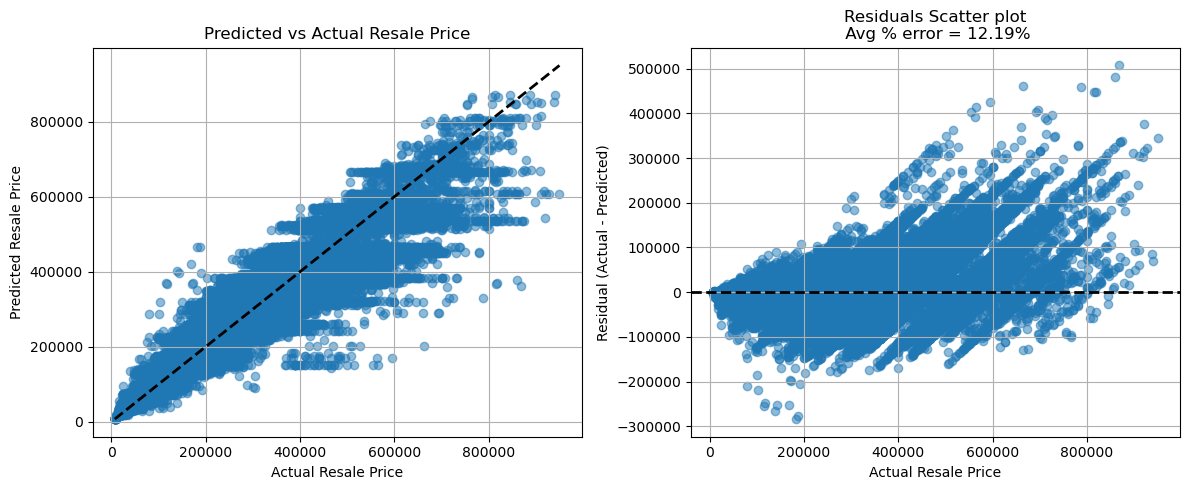

In [15]:
# Scatter plot: predicted vs actual resale prices
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_test_predict, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Resale Price')
plt.ylabel('Predicted Resale Price')
plt.title('Predicted vs Actual Resale Price')
plt.grid(True)

# RMSE as residual scatter plot
residuals = y_test - y_test_predict
rmse_values = rmse # Just absolute residuals (RMSE scalar but per-point residual = abs error)
#mape_values = np.abs((y_test - y_test_predict) / y_test) * 100

plt.subplot(1, 2, 2)
plt.scatter(y_test, residuals, alpha=0.5, label='Residuals')
plt.axhline(0, color='k', lw=2, linestyle='--')
plt.xlabel('Actual Resale Price')
plt.ylabel('Residual (Actual - Predicted)')
#plt.ylabel('Percentage Residual (Actual - Predicted)')
#plt.title(f'Residuals Scatter plot\nRMSE = {rmse:.2f}')
plt.title(f'Residuals Scatter plot\n Avg % error = {mape:.2f}%')
plt.grid(True)

plt.tight_layout()
plt.savefig("figures/RF_test_viz.pdf", dpi=300, bbox_inches='tight')
plt.show()

# Predicting with future data

In [16]:
y_future_predict=rf_model.predict(X_future)

y_future_true = future_target_df["resale_price"].values.astype(float)

future_rmse = np.sqrt(mean_squared_error(y_future_true, y_future_predict))
future_mape = np.mean(np.abs((y_future_true - y_future_predict) / y_future_true)) * 100
future_r2 = r2_score(y_future_true, y_future_predict)

print(f"Test RMSE: {future_rmse:.2f}")
print(f"Test Mean Absolute Percentage Error: {future_mape:.2f}%")
print(f"Test R^2 (Coefficient of Determination): {future_r2:.4f}")

if future_r2>0.9:
    print("Your predictive model is excellent!!")

Test RMSE: 131618.26
Test Mean Absolute Percentage Error: 18.28%
Test R^2 (Coefficient of Determination): 0.4572


In [17]:
# Ensure all inputs have the same length
assert len(future_feature_df) == len(future_target_df)  == len(y_future_predict), \
    "All inputs must have the same number of rows"

# Combine the two DataFrames side by side
final_future_df = pd.merge(
    future_feature_df,
    future_target_df,
    on='transaction_id',
    how='inner'   # use 'left', 'right', or 'outer' if needed
)

# Add y_test and y_test_predict as new columns
final_future_df['y_future_predict'] = y_future_predict

# Display the combined DataFrame
print(final_future_df.head())


   transaction_id  resale_year        town flat_type   flat_age  resale_price  \
0               1         2017  ANG MO KIO    2 ROOM  38.001369      232000.0   
1               2         2017  ANG MO KIO    3 ROOM  39.000684      250000.0   
2               3         2017  ANG MO KIO    3 ROOM  37.002053      262000.0   
3               4         2017  ANG MO KIO    3 ROOM  37.002053      265000.0   
4               5         2017  ANG MO KIO    3 ROOM  37.002053      265000.0   

   y_future_predict  
0     275080.680693  
1     348189.256385  
2     348189.256385  
3     348189.256385  
4     348189.256385  


Prediction for only next year

In [22]:
future_df_nextyear = final_future_df[final_future_df['resale_year'] == 2014]
y_future_true = future_df_nextyear['resale_price'].values.astype(float)
y_future_predict = future_df_nextyear['y_future_predict'].values.astype(float)

future_residuals_ny = y_future_true - y_future_predict
future_rmse_ny = np.sqrt(mean_squared_error(y_future_true, y_future_predict))
future_r2_ny = r2_score(y_future_true, y_future_predict)
future_mape_ny= np.mean(np.abs((y_future_true - y_future_predict) / y_future_true)) * 100

print(f"RMSE: ${future_rmse_ny:,.2f}")
print(f"Mean Absolute Percentage Error: {future_mape_ny:.2f}%")
print(f"R^2 (Coefficient of Determination): {future_r2_ny:.4f}")

RMSE: $65,723.96
Mean Absolute Percentage Error: 11.38%
R^2 (Coefficient of Determination): 0.7140


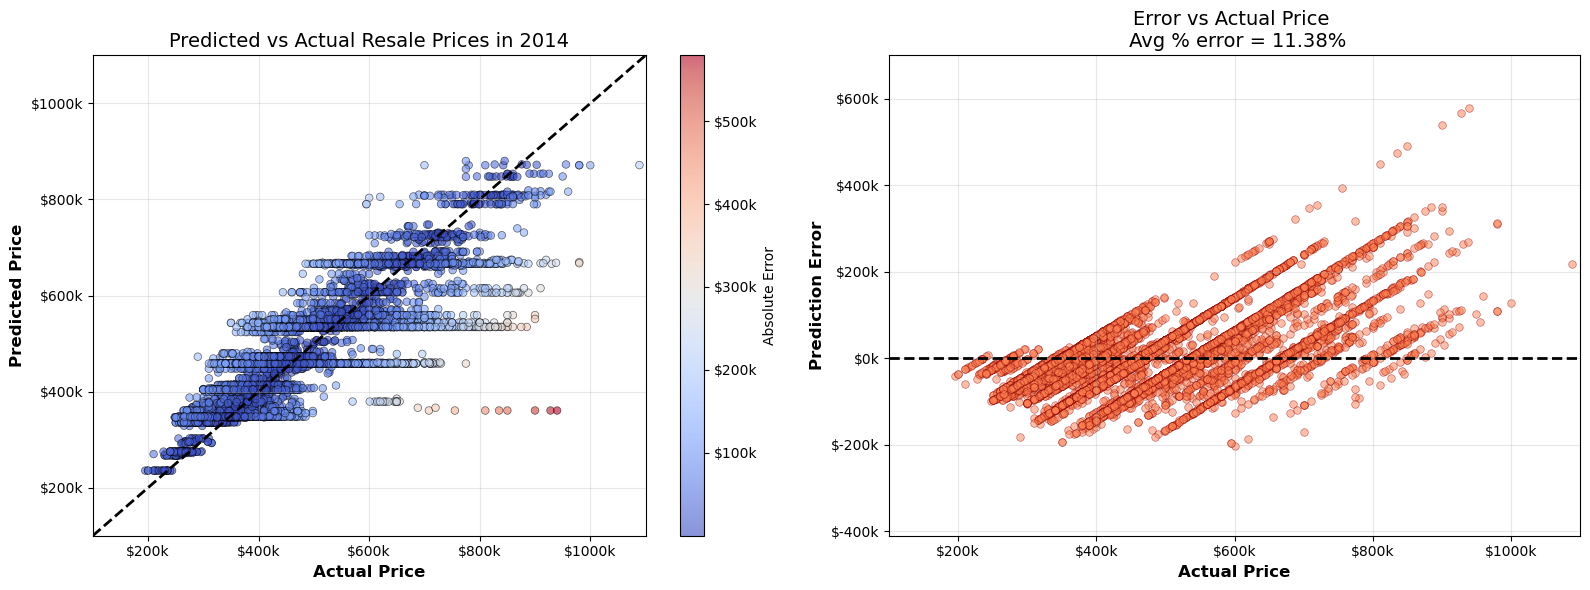

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Predicted vs Actual (color by error) ---
ax = axes[0]
abs_error = np.abs(y_future_true - y_future_predict)
scatter = ax.scatter(
    y_future_true, 
    y_future_predict, 
    c=abs_error,
    cmap='coolwarm',
    alpha=0.6,
    s=30,
    edgecolors='black',
    linewidth=0.5
)
#ax.plot([y_future_true.min(), y_future_true.max()],
#        [y_future_true.min(), y_future_true.max()], 'k--', lw=2)
x = np.linspace(100000, 1100000, 100)
ax.plot(x, x,'k--', linewidth=2, label=None)
ax.set_xlabel('Actual Price', fontsize=12, fontweight='bold')
ax.set_ylabel('Predicted Price', fontsize=12, fontweight='bold')
ax.set_title('Predicted vs Actual Resale Prices in 2014', fontsize=14)
ax.grid(True, alpha=0.3)
ax.set_xlim(100000, 1100000)
ax.set_ylim(100000, 1100000)
# Format axes in thousands with dollar sign
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}k'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}k'))

# Colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Absolute Error', fontsize=10) 
cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, p: f'${y/1000:.0f}k'))

# --- Residuals ---
ax = axes[1]
ax.scatter(y_future_true, future_residuals_ny, alpha=0.5, s=30, c='coral', edgecolors='darkred', linewidth=0.5)
ax.axhline(0, color='k', lw=2, linestyle='--')
ax.set_xlabel('Actual Price', fontsize=12, fontweight='bold')
ax.set_ylabel('Prediction Error', fontsize=12, fontweight='bold')
#ax.set_title(f'Coefficient of determination \n r2 = {future_r2:.2f}', fontsize=14)
ax.set_title(f"Error vs Actual Price \n Avg % error = {future_mape_ny:.2f}%", fontsize=14)
ax.grid(True, alpha=0.3)
ax.set_ylim(-410000, 700000)
ax.set_xlim(100000, 1100000)

# Format axes in thousands with dollar sign
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}k'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}k'))

plt.tight_layout()
plt.savefig("figures/RF_forecast_viz.pdf", dpi=300, bbox_inches='tight')
plt.show()

### Prediction for new data

In [20]:
def predict_resale_price(model, actual_df, flat_type, town, flat_age, resale_year=2014):
    """
    Predict resale price for a specific flat
    
    Parameters:
    -----------
    model_results : statsmodels results object
    training_columns : list of column names from training
    flat_type : str, e.g., '3 ROOM', '4 ROOM', '5 ROOM'
    town : str, e.g., 'ANG MO KIO', 'BEDOK'
    flat_age : float, age of flat in years
    resale_year : int, year of resale
    
    Returns:
    --------
    predicted_price : float
    """
    
    # Create input dataframe
    input_df = pd.DataFrame({
            'transaction_id': [0],  # Dummy ID
            'resale_year': [resale_year],
            'town': [town],
            'flat_age': [flat_age],
            'flat_type': [flat_type]
            })
    print(input_df.shape)
    
    X_input, _ = preprocess_features_pipeline(input_df,
            numeric_features=numeric_cols,
            categorical_features=categorical_cols,
            preprocessor=preprocessor,  # preprocessor fitted during training
            fit=False   
            )
  
    predicted_price = model.predict(X_input)

    # Find similar flats in actual data
    similar_flats = actual_df[
        (actual_df['flat_type'] == flat_type.upper()) &
        (actual_df['town'] == town.upper()) &
        (actual_df['flat_age'] >= flat_age - 2) &
        (actual_df['flat_age'] <= flat_age + 2) &
        (actual_df['resale_year'] == resale_year)
        #(actual_df['resale_year'] >= resale_year - 1) &
        #(actual_df['resale_year'] <= resale_year + 1)
    ]
    
    if len(similar_flats) > 0:
        print(f"\nSimilar Flats Found: {len(similar_flats)}")
        print(f"  Average Actual Price: ${similar_flats['resale_price'].mean():,.2f}")
        print(f"  Price Range: ${similar_flats['resale_price'].min():,.2f} - ${similar_flats['resale_price'].max():,.2f}")
        print(f"  Median: ${similar_flats['resale_price'].median():,.2f}")
    else:
        print("\nNo similar flats found in dataset")
    

    return predicted_price, similar_flats




In [21]:
predicted_price, similar_flats = predict_resale_price(
    model=rf_model,
    flat_type='4 ROOM',
    town='BEDOK',
    flat_age=25,
    resale_year=2014,
    actual_df=pd.merge(future_feature_df, future_target_df, on='transaction_id', how='inner')
)

print(f"\nPredicted Resale Price: {predicted_price[0]:.2f} SGD")

(1, 5)

Similar Flats Found: 4
  Average Actual Price: $452,472.00
  Price Range: $400,000.00 - $598,000.00
  Median: $405,944.00

Predicted Resale Price: 458397.36 SGD
